In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.base import BaseEstimator, ClassifierMixin
from os import listdir
from os.path import isfile, join

In [13]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b

    return gray

def blend_images(orig, four):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = 10, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, 0.8)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def get_ceps(picture):
    hm_len = picture.shape[0]
    bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
    bw2d = bw2d * bw2d.T
    log = np.log(np.abs(np.fft.fft2(picture * bw2d)))
    fourier_abs = np.abs(np.fft.ifft2(log))
    threshold = 0.5
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0

    return fourier_abs

class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - int(1/step))
        self.y_batches = int(picture.shape[0] // (batch_size * step) - int(1/step))
        self.picture = copy.deepcopy(picture)
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
#                 yield Cepstrum.calculate_cepstrum(self.picture[y * pixel_step : y * pixel_step + self.batch_size,
#                                    x * pixel_step : x * pixel_step + self.batch_size ])
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size ]))
#                 yield self.picture[y * pixel_step : y * pixel_step + self.batch_size,
#                                    x * pixel_step : x * pixel_step + self.batch_size ]

    def ft_array(self):
        temp_obj = np.ndarray((self.batch_size, self.batch_size), dtype='float')
        a = np.array(list(self.get_square()))
        self.output = a.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))

    def make_big_image(self, threshold=0.5):
        try:
            temp = [ 0 ] * self.y_batches
            for y in range(self.y_batches):
                temp[y] = np.hstack(self.output[y, :, :, :])
            self.big_image = np.vstack(temp)
#             return self.threshold_big_image()
            return self.big_image
        except AttributeError:
            print("!!! Use ft_array() function first !!!")
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
#         fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
#         fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        
#         fourier_abs *= (1.0/fourier_abs.max())
#         fourier_abs[fourier_abs < 0.1] = 0
        return fourier_abs
    
    def threshold_big_image(self, threshold=0.5):
        fourier_abs = self.big_image
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs < 0.1] = 0
        return self.big_image
    
    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    
def batch_generator(X, y, shuffle=True, batch_size=1):
    index = np.arange(y.shape[0])
    if shuffle:
        np.random.shuffle(index)
    j = 0
    for i in range(y.shape[0]//batch_size): 
        X_batch = X[index[j:j+batch_size]]
        y_batch = y[index[j:j+batch_size]]
        j+=batch_size
        yield (X_batch, y_batch)

def sigmoid(x):
    sigm_value_x = 1/(1+np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10, model_type='lin_reg',
                 batch_size=50, stop=0.05, th=0.5, warn=True):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.batch_size = batch_size
        self.meanerr = []
        self.stop = stop
        self.th = th
        self.warn = warn

    def calc_loss(self, X_batch, y_batch):
        N = y_batch.shape[0]
        ones = np.ones(N).reshape(y_batch.shape)
        X = np.column_stack((ones, X_batch))
        a = np.dot(X, self.weights).reshape(y_batch.shape)  # Prediction
        delta = 0.001
        if self.model_type == 'lin_reg':
            loss = np.dot((a-y_batch).T, (a-y_batch))/N
        else:
            a = sigmoid(a).reshape(y_batch.shape)
            loss = -(np.dot(y_batch.T, np.log(a+delta)) +
                     np.dot((ones-y_batch).T, np.log(ones-a+delta)))/N
        if self.C != 0:
            loss += np.dot(self.weights, self.weights)/self.C  # L2
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        N = y_batch.shape[0]
        ones = np.ones(N).reshape(y_batch.shape)
        X = np.column_stack((ones, X_batch))
        Xw = np.dot(X, self.weights).reshape(y_batch.shape)
        if self.model_type == 'lin_reg':
            loss_grad = np.dot(-2/N, np.dot(X.T, y_batch-Xw))
        else:
            a = sigmoid(Xw).reshape(y_batch.shape)
            loss_grad = -np.dot(X.T, y_batch - a)/N
        loss_grad = loss_grad.reshape(self.weights.shape)
        if self.C != 0:
            loss_grad += np.dot(2/self.C, self.weights)  # L2 grad
        return loss_grad/np.linalg.norm(loss_grad)

    def update_weights(self, new_grad):
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        self.weights = np.random.sample(X.shape[1]+1)
        stepsize = X.shape[0]//self.batch_size
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, True,
                                                       self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                self.update_weights(batch_grad)
            meanerr = np.array(self.errors_log['loss']
                               [n*stepsize:(n+1)*stepsize]).mean()
            self.meanerr.append(meanerr)
            if len(self.meanerr) > 30:
                changes = []
                for i in range(2, 30+2):
                    changes.append(abs(self.meanerr[-1]/self.meanerr[-i]-1))
                count = 0
                for i in changes:
                    if i < self.stop:
                        count += 1
                if count >= 25:  # Ошибка перестала изменяться
                    if self.warn:
                        print('study stop at epoch {0}, model={1}'
                              .format(n, self.model_type))
                    return
                else:
                    count = 0
        return self

    def predict(self, X):
        ones = np.ones(X.shape[0])
        X = np.column_stack((ones, X))
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights)
        else:
            if self.th is not None:
                y_hat = np.sign(sigmoid(np.dot(X, self.weights))-self.th)
                y_hat[y_hat == -1] = 0
            else:
                y_hat = sigmoid(np.dot(X, self.weights))
        return y_hat


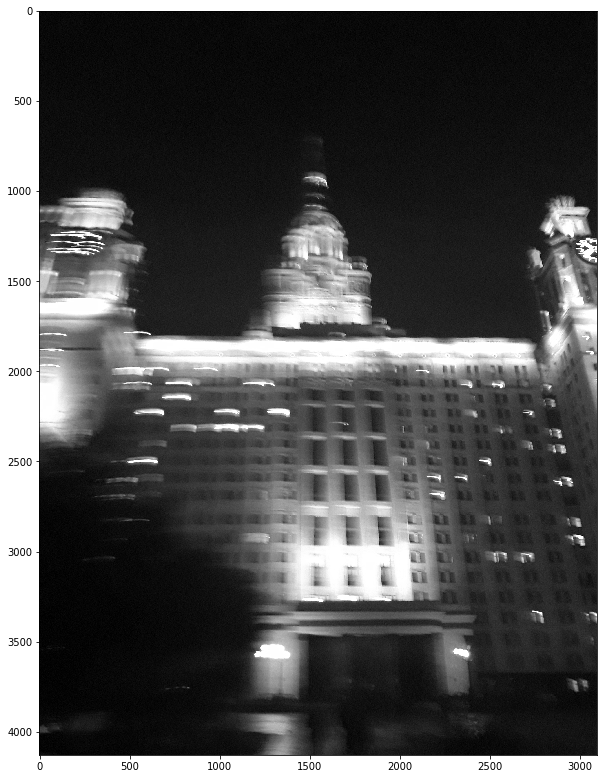

In [6]:
work_dir = "../pict/"
save_dir = "../res_02.12/"
# filename = "mb0.jpg"
filename = "mb1.jpg"

img = rgb2gray(plt.imread(work_dir + filename))

#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')
#ax2.imshow(b)

In [7]:
c = Cepstrum(img[1800 : 3000, 500 : 2000], batch_size=128, step=0.25)
# c = Cepstrum(img)
c.ft_array()

q = c.make_big_image()
plt.imsave('big_img.png', q, cmap='gray')

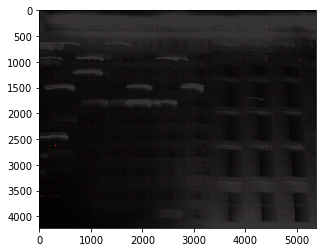

In [5]:
d = blend_images('orig_img.png', 'big_img.png')
imshow(np.asarray(d))
d.save(save_dir + filename[:-4] + "_" + str(c.batch_size) + '_' + str(c.step) + '_visualisation.png')

In [19]:
filenames = ['mb0.jpg', 'mb1.jpg']
b_sizes = [32, 64, 128]
steps = [0.25, 0.5]

# for filename in filenames:
filename = 'cm.PNG'
for batch_size in b_sizes:
    for step in steps:
        img = rgb2gray(plt.imread(work_dir + filename))
#         c = Cepstrum(img[2000:3500, 1000:2800], batch_size=batch_size, step=step)
        c = Cepstrum(img, batch_size=batch_size, step=step)
        c.ft_array()

        q = c.make_big_image()
        plt.imsave('big_img.png', q, cmap='gray')

        d = blend_images('orig_img.png', 'big_img.png')
        d.save(save_dir + filename[:-4] + "_" + str(c.batch_size) + '_' + str(c.step) + '_visualisation.png')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log
/home/lepossum/.local/lib/python3.6/site-packages/numpy/fft/fftpack.py:303: RuntimeWarning: invalid value encountered in multiply
  return output * (1 / (sqrt(n) if unitary else n))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater
/usr/lib/python3/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater


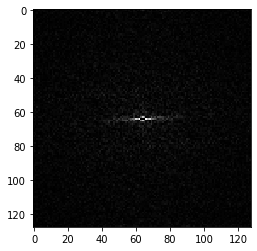

In [12]:
a = c.output[9, 8]
a = c.output[8, 6]
plt.imshow(a, cmap='gray')
plt.imsave('local_cep1.png', a, cmap='gray')

In [ ]:
train_X = np.ndarray((c.batch_size*c.batch_size, 2),dtype=float)
train_y = np.array([0]*c.batch_size*c.batch_size, dtype=float)

mid = c.batch_size//2

for i in range(c.batch_size):
    for j in range(c.batch_size):
#         train_X[i*c.batch_size + j, :] = [(i - mid)/mid, (j - mid)/mid]
        train_X[i*c.batch_size + j, :] = [i/c.batch_size, j/c.batch_size]
        train_y[i*c.batch_size + j] = a[i, j]

In [14]:
train_X = np.ndarray((c.batch_size*c.batch_size, 3),dtype=float)
train_y = np.array([0]*c.batch_size*c.batch_size, dtype=float)

mid = c.batch_size//2

for i in range(c.batch_size):
    for j in range(c.batch_size):
#         train_X[i*c.batch_size + j, :] = [(i - mid)/mid, (j - mid)/mid]
        train_X[i*c.batch_size + j, :] = [i/c.batch_size, j/c.batch_size]
        train_y[i*c.batch_size + j] = a[i, j]

In [15]:
train_X[:, 1]

array([0.       , 0.0078125, 0.015625 , ..., 0.9765625, 0.984375 ,
       0.9921875])

In [16]:
from sklearn import linear_model

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Variance score: 0.47
(20, 1) (20,)


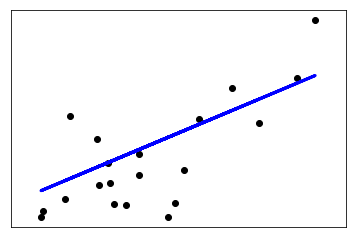

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

# Use only one feature

diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
print (diabetes_X_test.shape, diabetes_y_test.shape)

plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
reg = MySGDClassifier(batch_generator, C=100, alpha=0.01, max_epoch=1000, model_type='lin_reg', batch_size=50, stop=0.001)

reg.fit(train_X, train_y)


MySGDClassifier(C=100, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f690866fbf8>,
        batch_size=50, max_epoch=1000, model_type='lin_reg', stop=0.001,
        th=0.5, warn=True)

(16384, 2)
Coefficients: 
 [5.08186723e-07 4.37529319e-07]
Mean squared error: 0.00
Variance score: 0.00
(16384, 2) (16384,)


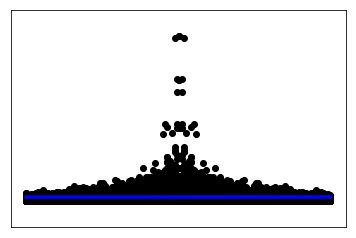

In [8]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
print (diabetes_X_test.shape, diabetes_y_test.shape)
plt.scatter(diabetes_X_test[:, 0], diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [22]:
a = rgb2gray(plt.imread('mb2_cepstrum.jpg'))
plt.imsave('mb2_cep.png', c.swap_quarters(a), cmap='gray')

In [ ]:
fname, kername = "lena.bmp", "an_large.png"
joj = rgb2gray(plt.imread("../pict/default_pics/" + fname))
ker = rgb2gray(plt.imread("../pict/kers/" + kername))
print(joj.shape, ker.shape)
q = ss.convolve2d(joj, ker)

In [ ]:
fnames = listdir("../pict/default_pics/")
kers = listdir("../pict/kers/")


for f in fnames:
    for k in kers:
        joj = rgb2gray(plt.imread("../pict/default_pics/" + f))
        ker = rgb2gray(plt.imread("../pict/kers/" + k))
        q = ss.convolve2d(joj, ker, mode='same')
        plt.imsave("../res_09_12/" + f[:-4] + "_" + k[:-4] + ".png", q, cmap='gray')

In [14]:
fnames = listdir("../res_09_12/")
fnames.remove('ceps')
fnames.remove('log')

for f in fnames:
    joj = rgb2gray(plt.imread("../res_09_12/" + f))
    q = c.swap_quarters(get_ceps(joj))
    plt.imsave("../res_09_12/ceps/" + f[:-4] + "_cep.png", q, cmap='gray')
    plt.imsave("../res_09_12/log/" + f[:-4] + "_log.png", c.swap_quarters(calculate_log(joj)), cmap='gray')
    

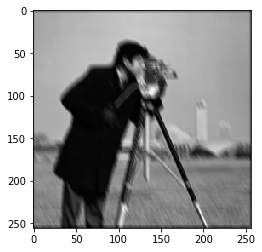

In [7]:
plt.imshow(q, cmap='gray')